In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture    
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, FunctionTransformer,StandardScaler,MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from sklearn.base import clone

In [2]:
import random 
random.seed(42) 


plt.rcParams.update({'font.size': 14})  

In [3]:
#Loading Dataset for CSV 
spotify_df=pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
marketing_df=pd.read_csv("marketing_campaign.csv",sep="\t") 

In [4]:
#Marketing Campaign 
# Creating are "target class"
marketing_df['AcceptedAny'] = (marketing_df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',"Response"]].sum(axis=1) > 0).astype(int)

# One hot encoding marital status
relationship_dict = {
    'Single': 0,
    'Together': 1,
    'Married': 1,
    'Divorced':0,
    'Widow': 0,
    'Alone': 0,
    'Absurd': 0,
    'YOLO': 0
}

marketing_df['Marital_Status'] = marketing_df['Marital_Status'].map(relationship_dict)


# Target Encoding for Education 
education_mapping = {
    'Basic': 0, 
    'Graduation': 1, 
    "2n Cycle":2,
    "Master":2,
    "Phd":3}


# transforming thet amount to being what is the distribution of their porchases money wise
marketing_df['Education'] = marketing_df['Education'].map(education_mapping)


marketing_df["Kidhome"]=marketing_df["Kidhome"]+marketing_df['Teenhome']


# Creating the 'birth_eras' column based on the bins
marketing_df['birth_eras'] =  2014 - marketing_df['Year_Birth']




marketing_df['NumAllPurchases'] = marketing_df['NumWebPurchases']+marketing_df['NumCatalogPurchases']+marketing_df['NumStorePurchases']

# Converting "Valance" into four classes 
bins = [-1, 20, 40, 60, 80, 101]
labels = [0, 1, 2, 3, 4]  # Numeric labels corresponding to each bin

# Use pd.cut to bin the data and assign the numeric labels directly
spotify_df['valence_%'] = pd.cut(spotify_df['valence_%'], bins=bins, labels=labels, right=True)




# Encoding Some of the Categorical variables
#Spotify 
# One hot encode Keys
spotify_df = pd.get_dummies(spotify_df, columns=['key'],dtype=int) 



# Label Encoding for mode 
mode_mapping = {'Major': 0, 'Minor': 1}

spotify_df['mode'] = spotify_df['mode'].map(mode_mapping)



In [5]:
#Drops Uneeded Categories and rows with null values, and the first column from one hot encoding

#Spotify Removal Of Uneeded 
spotify_df.drop(columns=['in_spotify_playlists', 'in_spotify_charts', 'streams',
                           'in_apple_playlists', 'in_apple_charts',
                           'in_deezer_charts', 'in_shazam_charts',"track_name","artist(s)_name","in_deezer_playlists","artist_count","released_day","released_year","released_month",'key_A'],axis =1,inplace=True) 
spotify_df.dropna(inplace=True)

#Marketing Removal Of Uneeded 
marketing_df.drop(columns=["ID","Year_Birth","Teenhome","Recency","Dt_Customer",'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response',"Z_CostContact","Z_Revenue"],axis =1,inplace=True) 
marketing_df.dropna(inplace=True)


In [6]:

spotify_df = spotify_df.apply(pd.to_numeric,errors='coerce') 
marketing_df=marketing_df.apply(pd.to_numeric,errors='coerce')  

spotify_df.dropna(inplace=True) 
marketing_df.dropna(inplace=True)


In [7]:
columns_to_check = ["Income"]

#Get Weird of weird outliers (i.e income)
z_scores = np.abs(stats.zscore(marketing_df[columns_to_check]))


threshold = 3


marketing_df = marketing_df[(z_scores < threshold).all(axis=1)]


In [8]:
x_spotify=spotify_df.drop(columns=["valence_%"])
y_spotify=spotify_df["valence_%"]
x_marketing= marketing_df.drop(columns=['AcceptedAny'])
y_marketing=marketing_df['AcceptedAny']


In [9]:
# Creates the Scaling Preproccesor for X Values
standard_categories = ['bpm']

percentage_categories = [ 'danceability_%', 'energy_%', 'acousticness_%', 
                      'instrumentalness_%', 'liveness_%']

# Define the transformers

def divide_by_100(X):
    return X / 100 

scaling_pipeline = Pipeline(steps=[
    ('standard_scaling', StandardScaler()),  
    ('min_max_scaling', MinMaxScaler())     
])

preprocessor_spotify = ColumnTransformer(
    transformers=[
        ('standard', scaling_pipeline, standard_categories), 
        ('percentage', scaling_pipeline, percentage_categories), 
         
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False  
)

# Scaling categories (Based on Training/Testing)
standard_categories = ['Education', 'Income', 'Kidhome', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumAllPurchases', 'NumWebVisitsMonth',"birth_eras"
       ]  

preprocessor_marketing = ColumnTransformer(
    transformers=[
        ('standard', scaling_pipeline, standard_categories),   
           
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False
)



In [10]:
X_spotify = x_spotify.copy()
X_marketing = x_marketing.copy()

In [11]:
len(x_marketing.iloc[0])
len(x_spotify.iloc[0])

18

In [12]:
print(len(x_marketing)) 
preprocessor_spotify.fit_transform(x_spotify)
x_spotify

1731


,bpm,mode,danceability_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,key_A#,key_B,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,125,0,80,83,31,0,8,4,0,1,0,0,0,0,0,0,0,0
1,92,0,71,74,7,0,10,4,0,0,1,0,0,0,0,0,0,0
2,138,0,51,53,17,0,31,6,0,0,0,0,0,0,1,0,0,0
3,170,0,55,72,11,0,11,15,0,0,0,0,0,0,0,0,0,0
4,144,1,65,80,14,63,11,6,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,144,0,60,39,57,0,8,3,0,0,0,0,0,0,0,0,0,0
949,166,0,42,24,83,1,12,6,0,0,0,0,0,0,0,1,0,0
950,92,0,80,67,4,0,8,6,0,0,1,0,0,0,0,0,0,0
951,97,0,82,77,8,0,12,5,0,0,1,0,0,0,0,0,0,0


In [13]:


X_spotify = x_spotify
X_marketing = x_marketing
# Function to calculate Silhouette Scores for multiple clusters(for both GMM and KMeans)
def calculate_silhouette_scores(pipeline, X, n_components_range, model_type='gmm'):
    silhouette_scores = []
    
    for n_components in n_components_range:
        
        if model_type == 'gmm':
            pipeline.named_steps['gmm'].n_components = n_components
        elif model_type == 'kmeans':
            pipeline.named_steps['kmeans'].n_clusters = n_components
        
       
        pipeline.fit(X)
        
            
        labels = pipeline.predict(X)

        print(f'{n_components} with {model_type}')
        print(np.unique(labels,return_counts=True))

        
        if len(np.unique(labels)) > 1:  
            score = silhouette_score(X, labels)
            
        else:
            score = -1  #On off chance of only 1 cluster
        silhouette_scores.append(score)
    
    return silhouette_scores


n_components_range = range(2, 20) 


# Create a pipeline with GMM
pipeline_gmm_spotify = Pipeline([
    ('preprocessor', preprocessor_spotify),  
    ('gmm', GaussianMixture(init_params='k-means++', max_iter=200,n_init=10,random_state=42))  
])

pipeline_gmm_marketing = Pipeline([
    ('preprocessor', preprocessor_marketing),  
    ('gmm', GaussianMixture(init_params='k-means++',max_iter=200,n_init=50,random_state=42)) 
])


pipeline_kmeans_spotify = Pipeline([
    ('preprocessor', preprocessor_spotify),
    ('kmeans', KMeans(init='k-means++',max_iter=200, n_init=50,random_state=42,algorithm="elkan")) 
])

pipeline_kmeans_marketing = Pipeline([
    ('preprocessor', preprocessor_marketing),  
    ('kmeans', KMeans(init='k-means++',max_iter=200, n_init=50,random_state=42,algorithm="elkan")) 
])







In [14]:
silhouette_gmm_marketing = calculate_silhouette_scores(pipeline_gmm_marketing, X_marketing, n_components_range, model_type='gmm')
silhouette_kmeans_marketing = calculate_silhouette_scores(pipeline_kmeans_marketing, X_marketing, n_components_range, model_type='kmeans')



2 with gmm
(array([0, 1]), array([944, 787]))
3 with gmm
(array([0, 1, 2]), array([785, 911,  35]))
4 with gmm
(array([0, 1, 2, 3]), array([610, 477, 615,  29]))
5 with gmm
(array([0, 1, 2, 3, 4]), array([380, 365, 600, 357,  29]))
6 with gmm
(array([0, 1, 2, 3, 4, 5]), array([330, 357, 347, 396, 286,  15]))
7 with gmm
(array([0, 1, 2, 3, 4, 5, 6]), array([ 21, 117, 424, 312, 449, 349,  59]))
8 with gmm
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([337, 307, 353, 282,  63,  19, 338,  32]))
9 with gmm
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 19,  83,  21, 282, 247,  17, 304, 339, 419]))
10 with gmm
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 18,  24,  67,  11,  58, 566,  20, 329, 316, 322]))
11 with gmm
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([119, 201,  18,  61, 355,  11, 527,  19,  19,   1, 400]))
12 with gmm
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 17, 318, 302, 320, 362,  20,  16, 252,  16,  24,  68,  16]))
13 with gmm
(array([ 0,  1, 

In [15]:
silhouette_gmm_spotify = calculate_silhouette_scores(pipeline_gmm_spotify, X_spotify, n_components_range, model_type='gmm')
silhouette_kmeans_spotify = calculate_silhouette_scores(pipeline_kmeans_spotify, X_spotify, n_components_range, model_type='kmeans')

2 with gmm
(array([0, 1]), array([475, 478]))
3 with gmm
(array([0, 1, 2]), array([534, 332,  87]))
4 with gmm
(array([0, 1, 2, 3]), array([ 57, 247, 288, 361]))
5 with gmm
(array([0, 1, 2, 3, 4]), array([218,  41, 176, 232, 286]))
6 with gmm
(array([0, 1, 2, 3, 4, 5]), array([ 41, 247, 255,  92,   2, 316]))
7 with gmm
(array([0, 1, 2, 3, 4, 5, 6]), array([ 29, 232, 161,  51, 216,   2, 262]))
8 with gmm
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 23, 194,   9, 181, 237,  36, 237,  36]))
9 with gmm
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 39,   9, 182,  29, 123, 183,   8,  69, 311]))
10 with gmm
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 39,   9, 183,  29, 124, 183,   8,  69, 307,   2]))
11 with gmm
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([216,   9,  10,   9,   9,   2, 204,  85, 173,  21, 215]))
12 with gmm
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 17,  83, 197,   7,   7, 113,  29, 181, 279,  23,   8,   9]))
13 with gmm
(array([ 0,  1, 

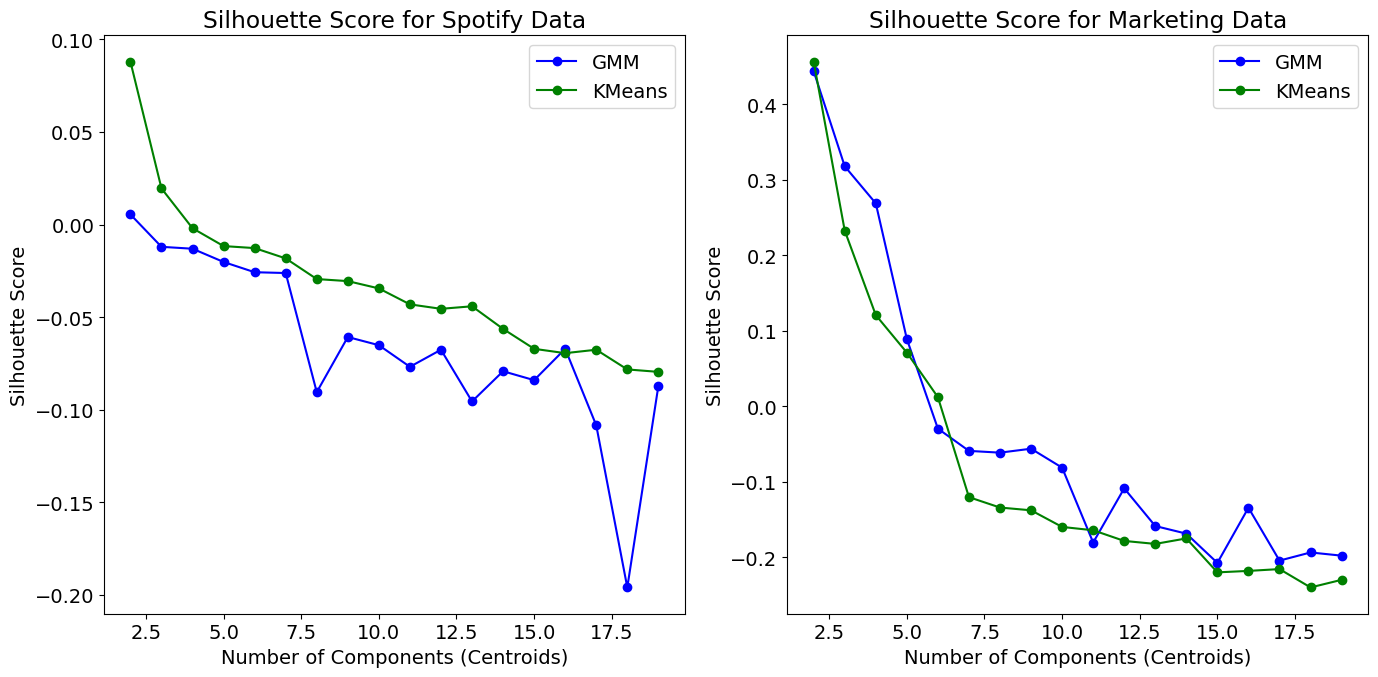

Optimal number of components for GMM on Spotify data: 2
Optimal number of components for KMeans on Spotify data: 2
Optimal number of components for GMM on Marketing data: 2
Optimal number of components for KMeans on Marketing data: 2


In [16]:

plt.figure(figsize=(14, 7))

# Subplot 1: Spotify - Silhouette Scores for GMM and KMeans
plt.subplot(1, 2, 1)
plt.plot(n_components_range, silhouette_gmm_spotify, marker='o', color='blue', label='GMM')
plt.plot(n_components_range, silhouette_kmeans_spotify, marker='o', color='green', label='KMeans')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spotify Data')
plt.legend()

# Subplot 2: Marketing - Silhouette Scores for GMM and KMeans
plt.subplot(1, 2, 2)
plt.plot(n_components_range, silhouette_gmm_marketing, marker='o', color='blue', label='GMM')
plt.plot(n_components_range, silhouette_kmeans_marketing, marker='o', color='green', label='KMeans')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Marketing Data')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Output the optimal number of components for both datasets for GMM and KMeans
optimal_gmm_spotify = n_components_range[np.argmax(silhouette_gmm_spotify)] 
optimal_kmeans_spotify = n_components_range[np.argmax(silhouette_kmeans_spotify)]  

optimal_gmm_marketing = n_components_range[np.argmax(silhouette_gmm_marketing)]  
optimal_kmeans_marketing = n_components_range[np.argmax(silhouette_kmeans_marketing)]

print(f"Optimal number of components for GMM on Spotify data: {optimal_gmm_spotify}")
print(f"Optimal number of components for KMeans on Spotify data: {optimal_kmeans_spotify}")
print(f"Optimal number of components for GMM on Marketing data: {optimal_gmm_marketing}")
print(f"Optimal number of components for KMeans on Marketing data: {optimal_kmeans_marketing}")

Getting the Similarity within Clusters

In [17]:
#Marketing Cosine Similarities 

pipeline_gmm_spotify = Pipeline([
    ('preprocessor', preprocessor_spotify),  
    ('gmm', GaussianMixture(n_components=2,init_params='k-means++', max_iter=200,n_init=10,random_state=42))  
])




pipeline_kmeans_spotify = Pipeline([
    ('preprocessor', preprocessor_spotify),  
    ('kmeans', KMeans(n_clusters=2,init='k-means++',max_iter=200, n_init=50,random_state=42,algorithm="elkan"))  
])



pipeline_kmeans_spotify.fit(x_spotify) 
labels_kmeans=pipeline_kmeans_spotify.predict(x_spotify)


pipeline_gmm_spotify.fit(x_spotify) 
labels_gmm=pipeline_gmm_spotify.predict(x_spotify)

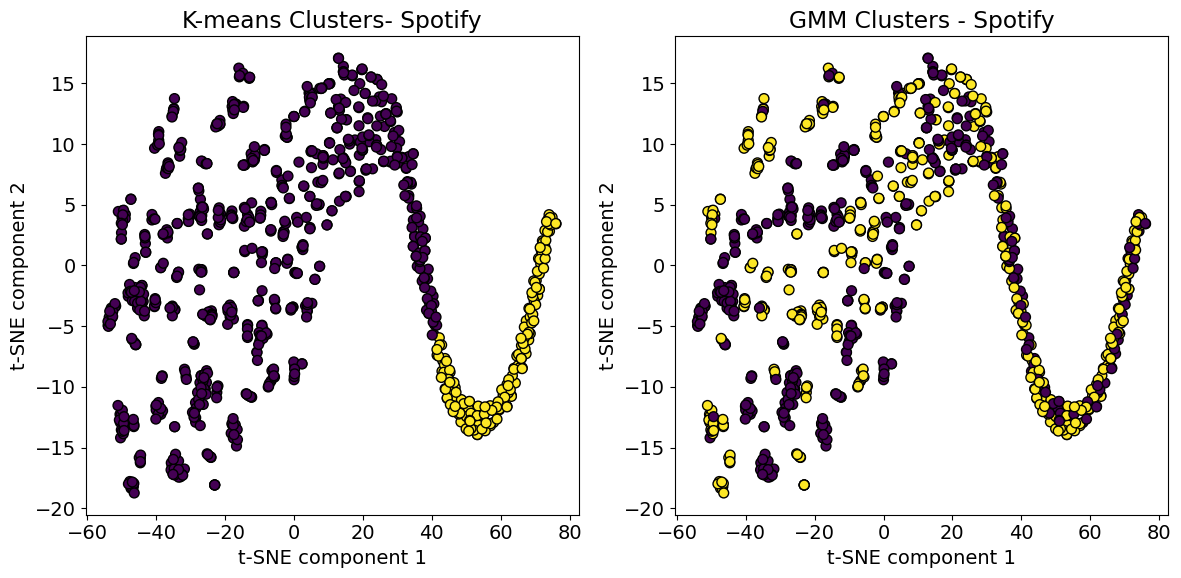

In [18]:
tsne = TSNE(n_components=2, random_state=42)


x_spotify_pre=preprocessor_spotify.fit_transform(x_spotify)
x_tsne = tsne.fit_transform(x_spotify_pre)

# Step 3: Plot the clusters for K-means
plt.figure(figsize=(12, 6))

# K-means Clustering Plot
plt.subplot(1, 2, 1)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_kmeans, cmap='viridis', edgecolor='k', s=50)
plt.title('K-means Clusters- Spotify')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# GMM Clustering Plot
plt.subplot(1, 2, 2)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_gmm, cmap='viridis', edgecolor='k', s=50)
plt.title('GMM Clusters - Spotify')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Show the plots
plt.tight_layout()
plt.show()

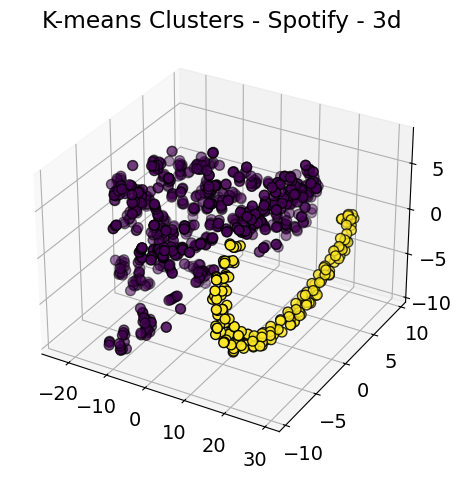

In [19]:

# Step 1: Apply t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42)

# Assuming `x_spotify` is your data and `preprocessor_spotify` is your preprocessor
x_spotify_pre = preprocessor_spotify.fit_transform(x_spotify)
x_tsne = tsne.fit_transform(x_spotify_pre)

# Step 2: Plot the clusters for K-means and GMM in 3D
fig = plt.figure(figsize=(12, 12))

# K-means Clustering Plot
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=labels_kmeans, cmap='viridis', edgecolor='k', s=50)
ax1.set_title('K-means Clusters - Spotify - 3d')

plt.show()


In [20]:
#Spotify Cosine Similarities 
pipeline_gmm_marketing = Pipeline([
    ('preprocessor', preprocessor_marketing),  # Apply preprocessing
    ('gmm', GaussianMixture(n_components=2 ,init_params='k-means++',max_iter=200,n_init=50,random_state=42)) 
])

pipeline_kmeans_marketing = Pipeline([
    ('preprocessor', preprocessor_marketing), 
    ('kmeans', KMeans(n_clusters=2, init='k-means++',max_iter=200, n_init=50,random_state=42,algorithm="elkan"))  
])


pipeline_kmeans_marketing.fit(x_marketing) 
labels_kmeans=pipeline_kmeans_marketing.predict(x_marketing)


pipeline_gmm_marketing.fit(x_marketing) 
labels_gmm=pipeline_gmm_marketing.predict(x_marketing)

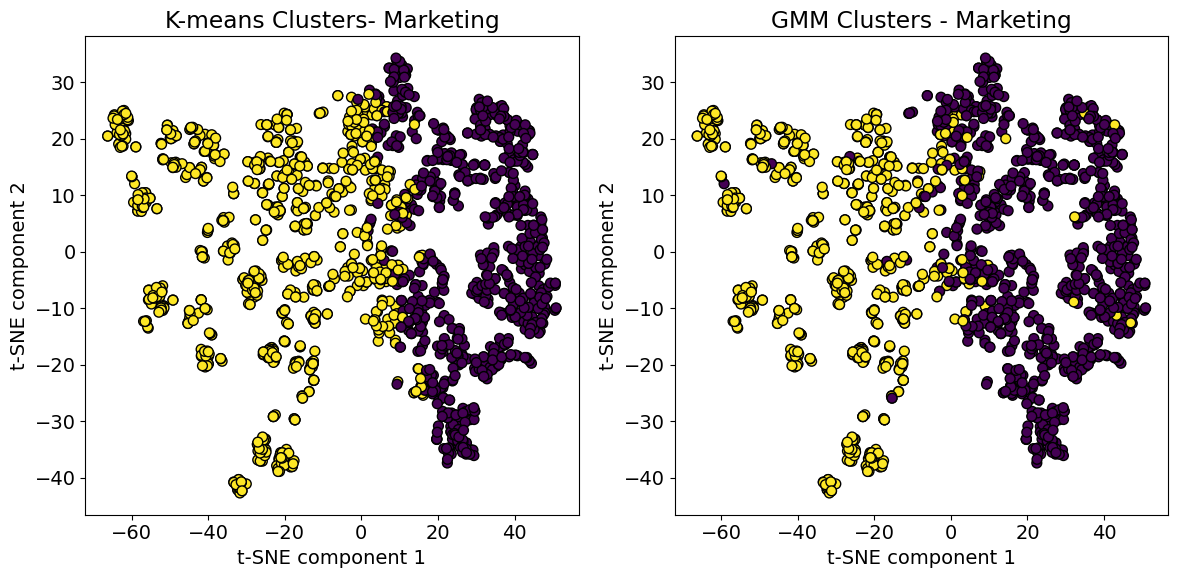

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
plt.rcParams.update({'font.size': 14})  # You can adjust the size (e.g., 14)

# Step 2: Use t-SNE to reduce the dimensionality of x_marketing
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to the data (x_marketing)
x_marketing_pre=preprocessor_marketing.fit_transform(x_marketing)
x_tsne = tsne.fit_transform(x_marketing_pre)

# Step 3: Plot the clusters for K-means
plt.figure(figsize=(12, 6))

# K-means Clustering Plot
plt.subplot(1, 2, 1)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_kmeans, cmap='viridis', edgecolor='k', s=50)
plt.title('K-means Clusters- Marketing')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# GMM Clustering Plot
plt.subplot(1, 2, 2)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_gmm, cmap='viridis', edgecolor='k', s=50)
plt.title('GMM Clusters - Marketing')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Show the plots
plt.tight_layout()
plt.show()